In [1]:
import datetime
import functools
import os
from typing import Sequence

from absl import app, flags
from absl import logging
import haiku as hk
import jax
import jax.numpy as jnp
from ml_collections import config_flags
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from nice import NICE
import os
from utils import flatten_nested_dict, update_config_dict, setup_training
import wandb
import numpy as np
import pickle

def load_dataset(
    split: str,
    batch_size: int,
    im_size: int,
    alpha: float,
    n_bits: int
):
  """Loads the dataset as a generator of batches."""
  ds, ds_info = tfds.load("mnist", split=split,
                          as_supervised=True, with_info=True)
  ds = ds.cache()
  ds = ds.map(lambda x, y: resize(x, y, im_size=im_size),
              num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda x, y: dequantize(x, y, n_bits=n_bits),
              num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda x, y: logit(x, y, alpha=alpha),
              num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.shuffle(ds_info.splits["train"].num_examples)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return tfds.as_numpy(ds)

def dequantize(x, y, n_bits=3):
  n_bins = 2. ** n_bits
  x = tf.cast(x, tf.float32)
  x = tf.floor(x / 2 ** (8 - n_bits))
  x = x / n_bins
  x = x + tf.random.uniform(x.shape) / n_bins
  return x, y


def resize(x, y, im_size=28):
  """Resize images to desired size."""
  x = tf.image.resize(x, (im_size, im_size))
  return x, y


def logit(x, y, alpha=1e-6):
  """Scales inputs to rance [alpha, 1-alpha] then applies logit transform."""
  x = x * (1 - 2 * alpha) + alpha
  x = tf.math.log(x) - tf.math.log(1. - x)
  return x, y


2023-09-11 22:53:27.300054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-11 22:53:27.906982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-11 22:53:27.907046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-11 22:53:27.907052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [5]:
from nice_config import get_config

config = get_config()

def forward_fn():
    flow = NICE(config.im_size ** 2, h_dim=config.hidden_dim)

    def _logpx(x):
        return flow.logpx(x)
    def _recons(x):
        return flow.reverse(flow.forward(x))
    def _sample():
        return flow.sample(config.batch_size)
    return _logpx, (_logpx, _recons, _sample)

forward = hk.multi_transform(forward_fn)
rng_seq = hk.PRNGSequence(config.seed)

In [6]:
artifact_name = f"{config.alpha}_{config.n_bits}_{config.im_size}"

api = wandb.Api()

artifact = api.artifact(f"shreyaspadhy/cais/{artifact_name}:latest")
params = pickle.load(open(artifact.file(), "rb"))
artifact_loaded = True
print(f'Loaded {artifact_name}')


Loaded 0.05_8_28


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-09-11 22:53:44.318569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-11 22:53:44.318653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-09-11 22:53:44.318690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-09-11 22:53:44.323251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-09-11 22:53:44.323284: W te

(1000, 784) (1000, 784)


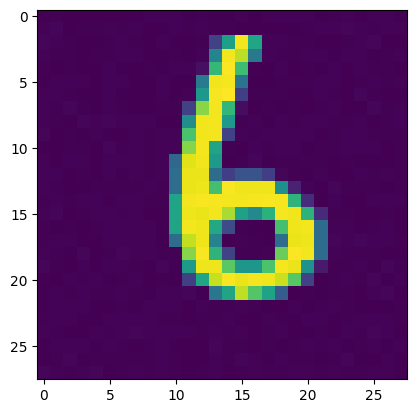

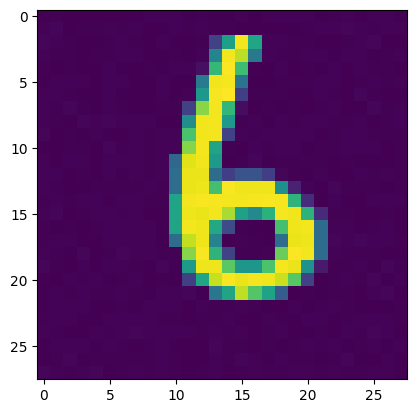

In [4]:
# load data
ds = load_dataset("train", config.batch_size, config.im_size, config.alpha,
                    config.n_bits)
ds_test = load_dataset("test", config.batch_size, config.im_size,
                        config.alpha, config.n_bits)

# get init data
x, _ = next(iter(ds))
x = x.reshape(x.shape[0], -1)

logpx_fn, recons_fn, sample_fn = forward.apply

params = forward.init(next(rng_seq), x)
x_re = recons_fn(params, next(rng_seq), x)

x_sample = sample_fn(params, next(rng_seq))

import matplotlib.pyplot as plt

print(x.shape, x_re.shape, x_sample.shape)

plt.imshow(x[0].reshape(28, 28))
plt.show()
plt.imshow(x_re[0].reshape(28, 28))
plt.show()

